In [1]:
import pandas as pd
import logging
import numpy as np
import matplotlib.collections as mcollections
from matplotlib.pylab import plt
import seaborn as sns
from matplotlib.lines import Line2D
import warnings
import ssl
from urllib.request import urlopen
%matplotlib inline

warnings.filterwarnings("ignore")

params = {"font.family":"Arial",
"legend.fontsize": 10,
        "axes.labelsize": 12,
        "axes.titlesize": 12,
        "xtick.labelsize": 12,
        "ytick.labelsize": 12,
        "svg.fonttype": 'none'}
plt.rcParams.update(params)

logger = logging.getLogger(__name__)
logging.basicConfig(level=logging.INFO)

### COLORS FOR ALTERATIONS
cmap_1 = plt.cm.get_cmap("Set2")
cmap_2 = plt.cm.get_cmap("tab20c")
GERMLINE_COLOR = cmap_1(5)
SOMATIC_COLOR = cmap_1(1)
GERMLINE_SOMATIC_COLOR = cmap_1(0)
BOXPLOT_COLOR = cmap_2(19)
NO_ALT_COLOR = cmap_2(17)


PALETTE = {"no alt":NO_ALT_COLOR, "germline+somatic":GERMLINE_SOMATIC_COLOR, "germline":GERMLINE_COLOR, "somatic":SOMATIC_COLOR}
OFFSET_METHYLATED = {"BRCA1": 0.65, 
                  "RAD51C": 0.55}

In [2]:
###########################################################################################
##### correlate fraction of methylation sites in HR genes and HRDetect results ############
###########################################################################################

def generate_HRDetect_plot_BRC_OVA(df_methyl_BRC_OVA, df_methyl_non_BRC_OVA, palette, offset_methylated):
    
    tumour_types = ["BRC_OVA", "non_BRC_OVA"]
    
    for tumour_type in tumour_types:
        if tumour_type == "BRC_OVA":
            ### Figure5a
            logger.info("generating HRDetect plots for BRC and OVA samples")
            df_methyl = df_methyl_BRC_OVA
        else:
            ### Ex Figure 5a
            logger.info("generating HRDetect plots for non BRC and OVA samples")
            df_methyl = df_methyl_non_BRC_OVA
        
        goi = ["BRCA1", "RAD51C"]
    
        fig_HRDetect, ax_HRDetect = plt.subplots(1, 2, sharex = False, sharey = False, figsize = (8.5, 4.5), dpi = 600)
        ax_HRDetect = ax_HRDetect.flatten()
        ### dummy figure
        fig_swarm, ax_swarm = plt.subplots(1, 2, sharex = False, sharey = True, figsize = (8.5, 4.5), dpi = 150)
        ax_swarm= ax_swarm.flatten()
        
        for gene_index, gene in enumerate(goi):
            logger.info(gene)
            df_plot_offset = df_methyl.copy()
            loh_column = gene+"_loh"
            
            for i in df_plot_offset.index:
                if gene == "BRCA1":
                    if df_plot_offset.loc[i, gene] >= offset_methylated[gene]:
                        df_plot_offset.loc[i, "methylated"] = "yes"
                    else:
                        df_plot_offset.loc[i, "methylated"] = "no"
                else:
                    if df_plot_offset.loc[i, gene] >= offset_methylated[gene]:
                        df_plot_offset.loc[i, "methylated"] = "yes"
                    else:
                        df_plot_offset.loc[i, "methylated"] = "no"
            
            df_plot_offset["LOH"] = np.nan
            for i in df_plot_offset.index:
                if "LOH" in df_plot_offset.loc[i, loh_column]:
                    df_plot_offset.loc[i, "LOH"] = "yes"
                else:
                    df_plot_offset.loc[i, "LOH"] = "no"
           
            swarm = sns.swarmplot(x="methylated", y = "HRDetect", data=df_plot_offset, ax = ax_swarm[gene_index])
            artists = swarm.get_children()
            offsets = {}
            for index, a in enumerate(artists):
                if (type(a) is mcollections.PathCollection) and len(a.get_offsets()) > 0:
                    offsets[index] = a.get_offsets()
    
            plt.close(fig_swarm)
    
            for index in df_plot_offset.index:
                if df_plot_offset.loc[index, "methylated"] == "no":
                    offset_index = 0
                else:
                    offset_index = 1
        
                minx = offsets[offset_index][0, 0]
                miny = offsets[offset_index][0, 1]
                for (x, y) in offsets[offset_index]:
                    
                    hrd = df_plot_offset.loc[index, "HRDetect"]
        
                    if abs(miny - hrd) > abs(y - hrd):
                        miny = y
                        minx = x
        
                df_plot_offset.loc[index, "x"] = minx
                df_plot_offset.loc[index, "y"] = miny
               
            sns.boxplot(x= "methylated", y = "HRDetect", data = df_plot_offset, ax = ax_HRDetect[gene_index], fliersize =2, linewidth = 0.6, color = "white")
            alt = None
            color = None
            for pog in df_plot_offset.index:
                alt = df_plot_offset.loc[pog, "HR_alt"]
                color = palette[alt]
                if df_plot_offset.loc[pog, "LOH"] == "yes":
                    ax_HRDetect[gene_index].scatter(df_plot_offset.loc[pog, "x"], df_plot_offset.loc[pog, "y"], marker = "o", s = 40, facecolors = "none", edgecolors = color, linewidth = 1.2)
                else:
                    ax_HRDetect[gene_index].scatter(df_plot_offset.loc[pog, "x"], df_plot_offset.loc[pog, "y"], marker = "o", s = 40, facecolors = color, edgecolors = color, linewidth = 1.0)
            
            somatic_circle = Line2D([0], [0], marker="o", color="w", label="somatic", markerfacecolor=SOMATIC_COLOR, markersize=8)
            germline_somatic_circle = Line2D([0], [0], marker="o", color="w", label="germline&somatic", markerfacecolor=GERMLINE_SOMATIC_COLOR, markersize=8)
            no_alt_circle =  Line2D([0], [0], marker="o", color="w", label="no alteration", markerfacecolor=NO_ALT_COLOR, markersize=8)
            loh_circle = Line2D([0], [0], marker="o", color="w", label="w LOH", markerfacecolor="white", markeredgecolor=NO_ALT_COLOR, markersize=6)
            no_loh_circle = Line2D([0], [0], marker="o", color="w", label="wo LOH", markerfacecolor=NO_ALT_COLOR, markersize=8)
            
            ax_HRDetect[gene_index].spines["right"].set_visible(False) 
            ax_HRDetect[gene_index].spines["top"].set_visible(False)
    
            ax_HRDetect[gene_index].set_title(gene)
            ax_HRDetect[gene_index].set_xticks(range(0,2))
    
        
            ax_HRDetect[gene_index].set_ylabel(None)
            ax_HRDetect[gene_index].set_xlabel(None)
            
            if gene_index == 0:
                ax_HRDetect[gene_index].set_ylabel("HRDetect score")
            
            ax_HRDetect[gene_index].set_xlabel("promoter methylation")
            
            if gene_index == 1:
                ax_HRDetect[gene_index].set_yticklabels("")
    
        fig_HRDetect.legend(handles = [no_alt_circle, somatic_circle, germline_somatic_circle, loh_circle, no_loh_circle], frameon=False, ncol= 5, loc="lower center", bbox_to_anchor=(0.5, -0.05), handletextpad=0.05, columnspacing=0.2)
        fig_HRDetect.tight_layout()


def generate_TPM_plot_BRCA_OVA(df_methyl_BRC_OVA, df_BRCA1_RAD51C_logTPM, palette):
    logger.info("generating TPM plots for BRC and OVA samples")
    
    goi = ["BRCA1", "RAD51C"]
    fig_TPM_BRC_OVA, ax_TPM_BRC_OVA = plt.subplots(1, 2, sharex = False, sharey = False, figsize = (8.5, 4.5), dpi = 600)
    ax_TPM_BRC_OVA = ax_TPM_BRC_OVA.flatten()
    ### dummy figure
    fig_swarm, ax_swarm = plt.subplots(1, 2, sharex = False, sharey = False, figsize = (9, 5), dpi = 150)
    ax_swarm= ax_swarm.flatten()

    for gene_index, gene in enumerate(goi):
        logger.info(gene)
        loh_column = gene+"_loh"
        df_fraction_plot = df_methyl_BRC_OVA[gene].to_frame()
        df_TPM_plot = df_BRCA1_RAD51C_logTPM[gene].to_frame()

        df_TPM_fraction = df_fraction_plot.merge(df_TPM_plot, how = "left", left_index = True, right_index = True)
        df_TPM_fraction.columns = ["fraction", "log2(TPM)"]

        for i in df_TPM_fraction.index:
            if gene == "BRCA1":
                if df_TPM_fraction.loc[i, "fraction"] >= 0.65:
                    df_TPM_fraction.loc[i, "methylated"] = "yes"
                else:
                    df_TPM_fraction.loc[i, "methylated"] = "no"
            else:
                if df_TPM_fraction.loc[i, "fraction"] >= 0.55:
                    df_TPM_fraction.loc[i, "methylated"] = "yes"
                else:
                    df_TPM_fraction.loc[i, "methylated"] = "no"
       
        for pog in df_TPM_fraction.index:
            HR_alt = df_methyl_BRC_OVA.loc[pog, "HR_alt"]
            BRCA1_loh = df_methyl_BRC_OVA.loc[pog, "BRCA1_loh"]
            RAD51C_loh = df_methyl_BRC_OVA.loc[pog, "RAD51C_loh"]
            df_TPM_fraction.loc[pog, "HR_alt"] = HR_alt
            df_TPM_fraction.loc[pog, "BRCA1_loh"] = BRCA1_loh
            df_TPM_fraction.loc[pog, "RAD51C_loh"] = RAD51C_loh

        df_TPM_fraction["LOH"] = np.nan
        for i in df_TPM_fraction.index:
            if "LOH" in df_TPM_fraction.loc[i, loh_column]:
                df_TPM_fraction.loc[i, "LOH"] = "yes"
            else:
                df_TPM_fraction.loc[i, "LOH"] = "no"

        swarm = sns.swarmplot(x="methylated", y = "log2(TPM)", data=df_TPM_fraction, ax = ax_swarm[gene_index])
        artists = swarm.get_children()
        offsets = {}
        for index, a in enumerate(artists):
            if (type(a) is mcollections.PathCollection) and len(a.get_offsets()) > 0:
                offsets[index] = a.get_offsets()

        plt.close(fig_swarm)
        
        for index in df_TPM_fraction.index:
            if df_TPM_fraction.loc[index, "methylated"] == "no":
                offset_index = 0
            else:
                offset_index = 1

            minx = offsets[offset_index][0, 0]
            miny = offsets[offset_index][0, 1]
            for (x, y) in offsets[offset_index]:
                
                tpm = df_TPM_fraction.loc[index, "log2(TPM)"]

                if abs(miny - tpm) > abs(y - tpm):
                    miny = y
                    minx = x

            df_TPM_fraction.loc[index, "x"] = minx
            df_TPM_fraction.loc[index, "y"] = miny

        sns.boxplot(x= "methylated", y = "log2(TPM)", data = df_TPM_fraction, ax = ax_TPM_BRC_OVA[gene_index], fliersize =2, linewidth = 0.6, color = "white")
        alt = None
        color = None
        for pog in df_TPM_fraction.index:
            alt = df_TPM_fraction.loc[pog, "HR_alt"]
            color = palette[alt]
            if df_TPM_fraction.loc[pog, "LOH"] == "yes":
                ax_TPM_BRC_OVA[gene_index].scatter(df_TPM_fraction.loc[pog, "x"], df_TPM_fraction.loc[pog, "y"], marker = "o", s= 40, facecolors = "none", edgecolors = color, linewidth = 1.2)
            else:
                ax_TPM_BRC_OVA[gene_index].scatter(df_TPM_fraction.loc[pog, "x"], df_TPM_fraction.loc[pog, "y"], marker = "o", s= 40, facecolors = color, edgecolors = color, linewidth = 1.0)

        somatic_circle = Line2D([0], [0], marker="o", color="w", label="somatic", markerfacecolor=SOMATIC_COLOR, markersize=8)
        germline_somatic_circle = Line2D([0], [0], marker="o", color="w", label="germline&somatic", markerfacecolor=GERMLINE_SOMATIC_COLOR, markersize=8)
        no_alt_circle =  Line2D([0], [0], marker="o", color="w", label="no alteration", markerfacecolor=NO_ALT_COLOR, markersize=8)
        loh_circle = Line2D([0], [0], marker="o", color="w", label="w LOH", markerfacecolor="white", markeredgecolor=NO_ALT_COLOR, markersize=6)
        no_loh_circle = Line2D([0], [0], marker="o", color="w", label="wo LOH", markerfacecolor=NO_ALT_COLOR, markersize=8)

        ax_TPM_BRC_OVA[gene_index].spines["right"].set_visible(False) 
        ax_TPM_BRC_OVA[gene_index].spines["top"].set_visible(False)

        ax_TPM_BRC_OVA[gene_index].set_title(gene)
        ax_TPM_BRC_OVA[gene_index].set_xticks(range(0,2))

        ax_TPM_BRC_OVA[gene_index].set_ylabel(None)
        ax_TPM_BRC_OVA[gene_index].set_xlabel(None)

        ax_TPM_BRC_OVA[gene_index].set_yticks(range(0,8))
        ax_TPM_BRC_OVA[gene_index].set_ylim(-1.2, 6)

        if gene_index == 0:
            ax_TPM_BRC_OVA[gene_index].set_ylabel("log2(TPM)")

        if gene_index == 1:
            # ax_TPM_BRC_OVA[gene_index].spines["left"].set_visible(False)
            ax_TPM_BRC_OVA[gene_index].set_yticklabels("")
            # ax_TPM_BRC_OVA[gene_index].set_yticks([])
        
        ax_TPM_BRC_OVA[gene_index].set_xlabel("promoter methylation")

    fig_TPM_BRC_OVA.legend(handles = [no_alt_circle, somatic_circle, germline_somatic_circle, loh_circle, no_loh_circle], frameon=False, ncol= 5, loc="lower center", bbox_to_anchor=(0.5, -0.05), handletextpad=0.05, columnspacing=0.2)
    fig_TPM_BRC_OVA.tight_layout()
    

INFO:__main__:generating HRDetect plots for BRC and OVA samples
INFO:__main__:BRCA1
INFO:__main__:RAD51C
INFO:__main__:generating HRDetect plots for non BRC and OVA samples
INFO:__main__:BRCA1
INFO:__main__:RAD51C
INFO:__main__:generating TPM plots for BRC and OVA samples
INFO:__main__:BRCA1
INFO:__main__:RAD51C


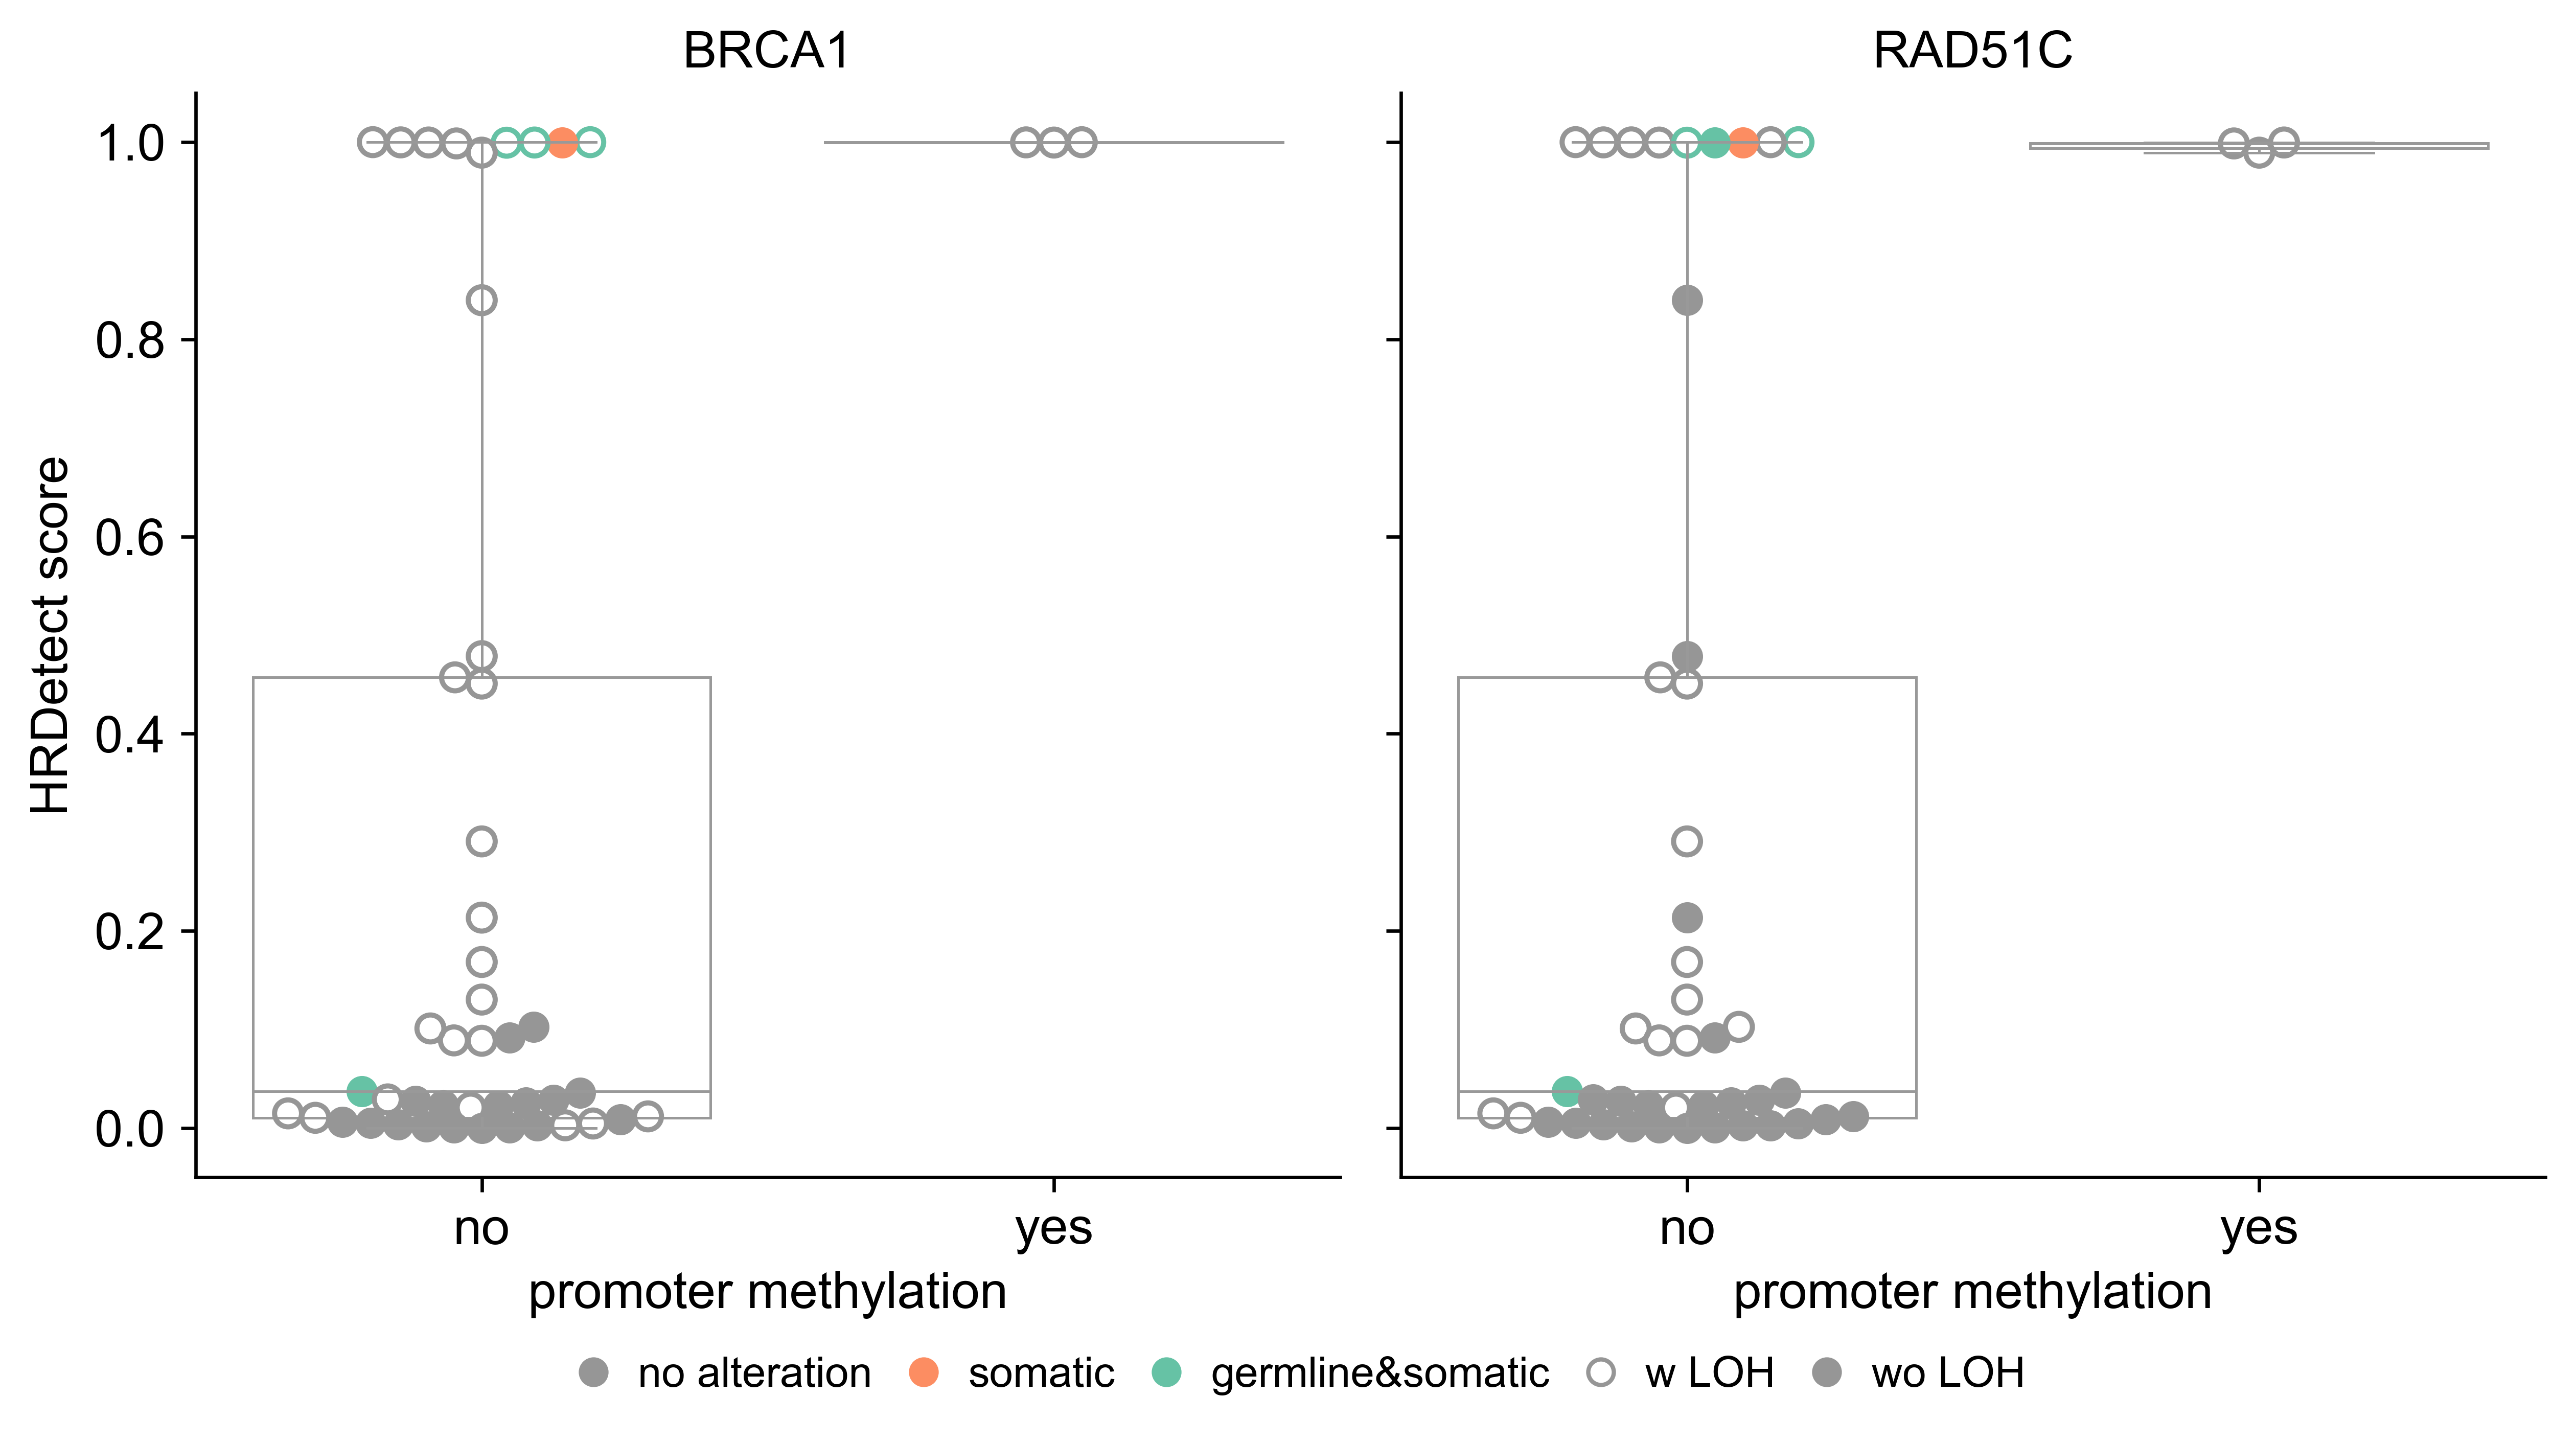

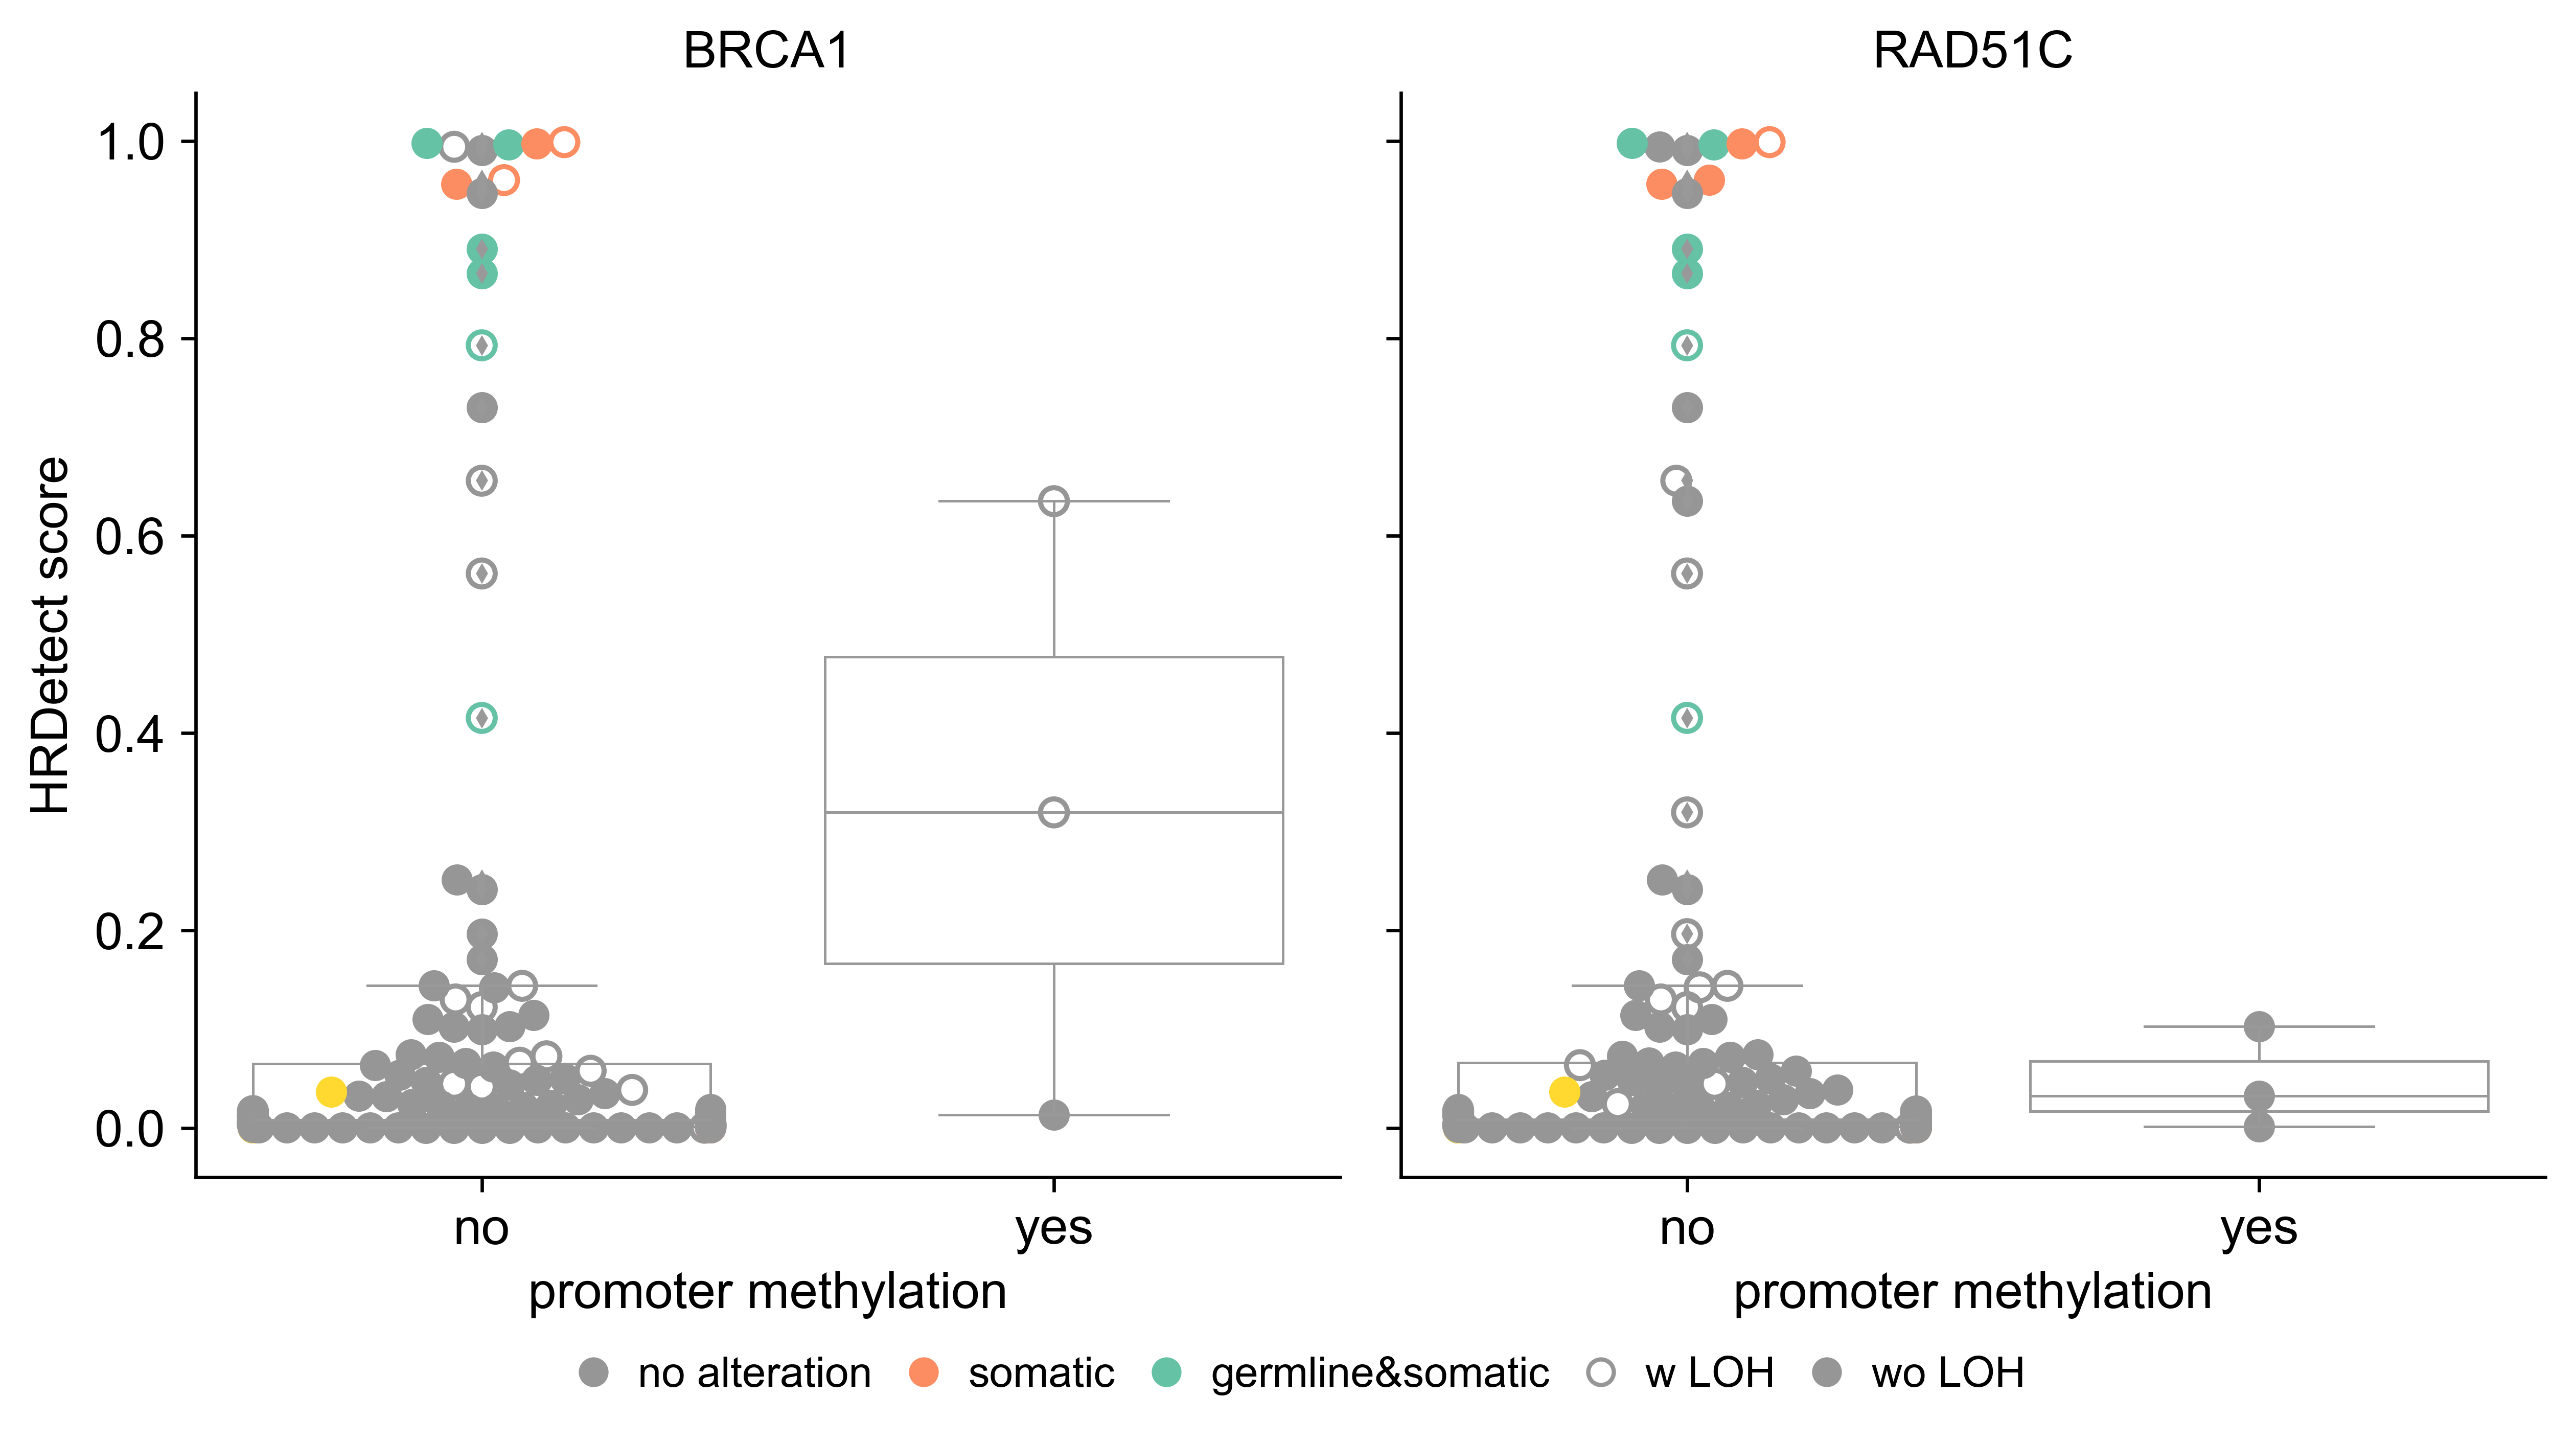

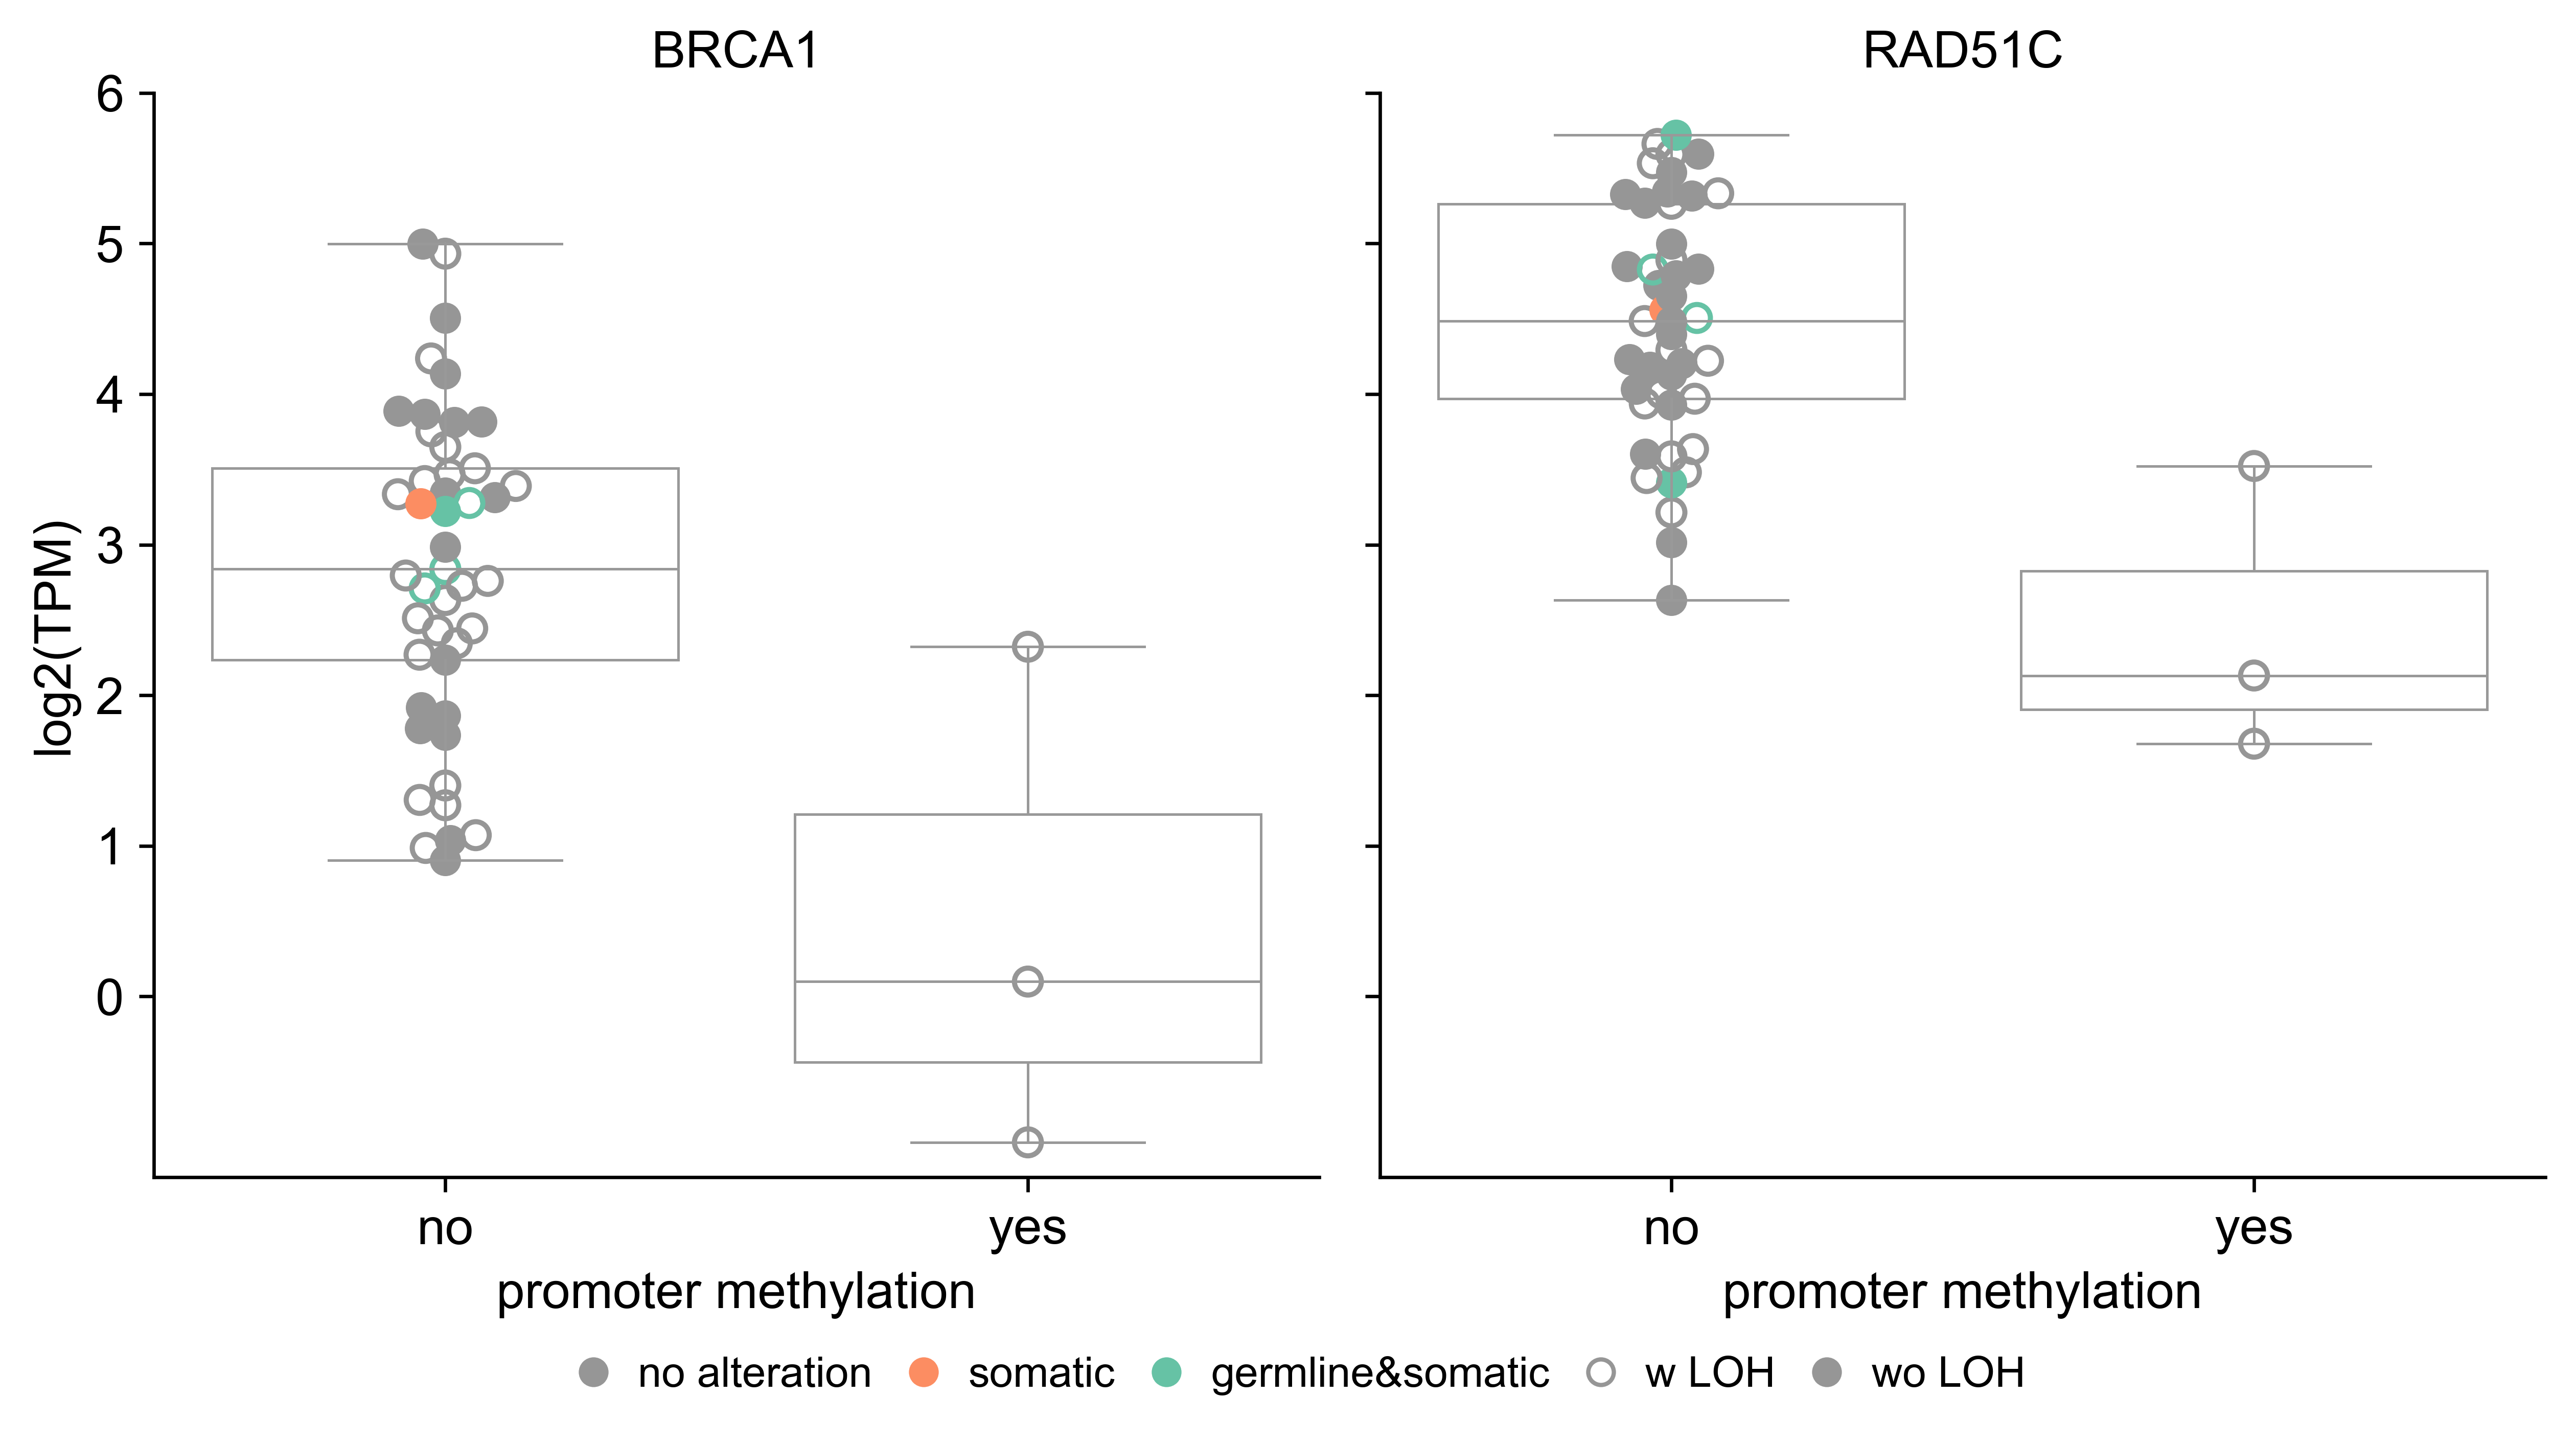

In [3]:
def main():
    filename_methyl_fraction_BRC_OVA =r"https://www.bcgsc.ca/downloads/nanopore_pog/ts_methylation//BRCA1_RAD51C_fraction_of_methylated_sites_BRC_OVA.tsv" 
    filename_methyl_fraction_non_BRC_OVA = r"https://www.bcgsc.ca/downloads/nanopore_pog/ts_methylation//BRCA1_RAD51C_fraction_of_methylated_sites_non_BRC_OVA.tsv"
    filename_BRCA1_RAD51C_logTPM = r"https://www.bcgsc.ca/downloads/nanopore_pog/ts_methylation//BRCA1_RAD51C_logTPM.tsv"
    
    context=ssl.create_default_context()
    context.set_ciphers("DEFAULT")
    
    result_BRC_OVA = urlopen(filename_methyl_fraction_BRC_OVA, context=context)
    result_non_BRC_OVA = urlopen(filename_methyl_fraction_non_BRC_OVA, context=context)
    result_BRCA1_RAD51C_logTPM = urlopen(filename_BRCA1_RAD51C_logTPM, context=context)
    
    df_methyl_BRC_OVA = pd.read_csv(result_BRC_OVA, sep = "\t", index_col = "tumour_original_source")
    df_methyl_non_BRC_OVA = pd.read_csv(result_non_BRC_OVA, sep = "\t", index_col = "tumour_original_source")
    df_BRCA1_RAD51C_logTPM = pd.read_csv(result_BRCA1_RAD51C_logTPM, sep = "\t", index_col = "tumour_original_source")


    generate_HRDetect_plot_BRC_OVA(df_methyl_BRC_OVA, df_methyl_non_BRC_OVA, PALETTE, OFFSET_METHYLATED)
    
    generate_TPM_plot_BRCA_OVA(df_methyl_BRC_OVA, df_BRCA1_RAD51C_logTPM, PALETTE)
    
if __name__ == "__main__":
    try:
        main()
    except Exception as err:
        logger.critical("Failure: %s", err, exc_info=True)